# Multilayer Perceptron

A Multilayer Perceptron (MLP) is a type of feedforward neural network that consists of three or more layers: an input layer, one or more hidden layers, and an output layer. Each layer is made up of neurons that use nonlinear activation functions, with each neuron connected to all neurons in the previous and next layers.

In this note book, we will start with linear regression model which we implemented last week. This notebook is consist of:
1. Linear Regression Model in PyTorch
2. Logistic Regression Model in PyTorch
3. Multilayer Preceptron (MLP) for Both Linear and Logistic Regression Models
3. Comparison with "Common-sense Linear Regression Model" and Statsmodel Benchmark


In [31]:
import torch
import numpy as np

import pandas as pd
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [32]:
from google.colab import files
uploaded = files.upload()

Saving Ames_cleaned.csv to Ames_cleaned (1).csv


## Linear Regression Model

We will be using Ames dataset, which we used last week. This time, we will take a deeper look into its data cleaning steps.

In [33]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd

# We use Ames data which we used in 142A/242A. I have already did data cleaning on this dataset.
# The processed dataset will be used for statsmodel.
ames = pd.read_csv('Ames_cleaned.csv')

# Change some columns to category data type
ames.drop(columns = ['MiscFeature'],inplace=True)
ames[['MoSold']]=ames[['MoSold']].astype('category')
ames[['OverallQual','OverallCond']]=ames[['OverallQual','OverallCond']].astype('category')

categorical_cols = ['MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                    'BsmtFinType2', 'Electrical', 'GarageFinish', 'GarageQual', 'GarageCond']

for var in categorical_cols:
    ames.loc[(ames[var]).isna(), [var]] = 'NaN'

ames[categorical_cols]=ames[categorical_cols].astype('category')

# This is used to be int type columns
discrete_cols = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
                 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'MSSubClass']
ames[discrete_cols] = ames[discrete_cols].astype('int').astype('category')

# Change remaining categorical variable types into 'category' type
still_categorical = ames.columns[ames.dtypes == 'object']
ames[still_categorical] = ames[still_categorical].astype('category')



In [34]:
ames.head(5)

,LogSalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,X1stFlrSF,X2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,X3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Artery,Feedr,Norm,PosA,PosN,RRAe,RRAn,RRNe,RRNn,AsbShng,AsphShn,BrkCmn,BrkComm,BrkFace,CBlock,CemntBd,CmentBd,HdBoard,ImStucc,MetalSd,Other,Plywood,PreCast,Stone,Stucco,VinylSd,WdSdng,WdShing,WdShng,YearsSince1950Built,YearsSince1950Remod,YearsSince1950GarageBuilt
0,12.278393,20,RL,141.0,31770.0,Pave,NoAccess,IR1,Lvl,AllPub,Corner,Gtl,NAmes,1Fam,1Story,6,5,Hip,CompShg,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656.0,0.0,0.0,1656.0,1,0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,Fin,2,528.0,TA,TA,P,210.0,62.0,0.0,0.0,0.0,0.0,NoPool,NoFence,0.0,5,2010,WD,Normal,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,10,10,10.0
1,11.561716,20,RH,80.0,11622.0,Pave,NoAccess,Reg,Lvl,AllPub,Inside,Gtl,NAmes,1Fam,1Story,5,6,Gable,CompShg,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896.0,0.0,0.0,896.0,0,0,1,0,2,1,TA,5,Typ,0,NoFirePlace,Attchd,Unf,1,730.0,TA,TA,Y,140.0,0.0,0.0,0.0,120.0,0.0,NoPool,MnPrv,0.0,6,2010,WD,Normal,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,11,11,11.0
2,12.055250,20,RL,81.0,14267.0,Pave,NoAccess,IR1,Lvl,AllPub,Corner,Gtl,NAmes,1Fam,1Story,6,6,Hip,CompShg,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329.0,0.0,0.0,1329.0,0,0,1,1,3,1,Gd,6,Typ,0,NoFirePlace,Attchd,Unf,1,312.0,TA,TA,Y,393.0,36.0,0.0,0.0,0.0,0.0,NoPool,NoFence,12500.0,6,2010,WD,Normal,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,8,8,8.0
3,12.404924,20,RL,93.0,11160.0,Pave,NoAccess,Reg,Lvl,AllPub,Corner,Gtl,NAmes,1Fam,1Story,7,5,Hip,CompShg,NaN,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110.0,0.0,0.0,2110.0,1,0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,Fin,2,522.0,TA,TA,Y,0.0,0.0,0.0,0.0,0.0,0.0,NoPool,NoFence,0.0,4,2010,WD,Normal,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,18,18.0
4,12.154253,60,RL,74.0,13830.0,Pave,NoAccess,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,1Fam,2Story,5,5,Gable,CompShg,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928.0,701.0,0.0,1629.0,0,0,2,1,3,1,TA,6,Typ,1,TA,Attchd,Fin,2,482.0,TA,TA,Y,212.0,34.0,0.0,0.0,0.0,0.0,NoPool,MnPrv,0.0,3,2010,WD,Normal,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,47,48,47.0


In [35]:
# Dummy Encoding
ames_encoded = pd.get_dummies(ames.select_dtypes(include=['category']))
ames_encoded = pd.concat([ames.select_dtypes(exclude=['category']),ames_encoded],axis=1)
ames_encoded

,LogSalePrice,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,X1stFlrSF,X2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,X3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,Artery,Feedr,Norm,PosA,PosN,RRAe,RRAn,RRNe,RRNn,AsbShng,AsphShn,BrkCmn,BrkComm,BrkFace,CBlock,CemntBd,CmentBd,HdBoard,ImStucc,MetalSd,Other,Plywood,PreCast,Stone,Stucco,VinylSd,WdSdng,WdShing,WdShng,YearsSince1950Built,YearsSince1950Remod,YearsSince1950GarageBuilt,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_A,MSZoning_C,MSZoning_FV,MSZoning_I,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_NoAccess,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,Utilities_NoSewr,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,...,TotRmsAbvGrd_7,TotRmsAbvGrd_8,TotRmsAbvGrd_9,TotRmsAbvGrd_10,TotRmsAbvGrd_11,TotRmsAbvGrd_12,TotRmsAbvGrd_13,TotRmsAbvGrd_14,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,Functional_Sev,Functional_Typ,Fireplaces_0,Fireplaces_1,Fireplaces_2,Fireplaces_3,Fireplaces_4,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_NoFirePlace,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NoGarage,GarageFinish_Fin,GarageFinish_NaN,GarageFinish_NoGarage,GarageFinish_RFn,GarageFinish_Unf,GarageCars_0,GarageCars_1,GarageCars_2,GarageCars_3,GarageCars_4,GarageCars_5,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_NaN,GarageQual_NoGarage,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_NaN,GarageCond_NoGarage,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_NoPool,PoolQC_TA,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_NoFence,MoSold_1,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_VWD,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,12.278393,141.0,31770.0,112.0,639.0,0.0,441.0,1080.0,1656.0,0.0,0.0,1656.0,528.0,210.0,62.0,0.0,0.0,0.0,0.0,0.0,2010,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,10,10,10.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,True,False,False,False,False,False,False,True,True,False,False,True,False,False,False,False,True,False,False,...,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False
1,11.561716,80.0,11622.0,0.0,468.0,144.0,270.0,882.0,896.0,0.0,0.0,896.0,730.0,140.0,0.0,0.0,0.0,120.0,0.0,0.0,2010,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,11,11,11.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,F

In [36]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Scale our data: Scaling is actually important when using SGD based optimizer. We will see the effect later.

# # Select columns with dtype float
cols = ames_encoded.select_dtypes(include=['float','int']).columns

# Exclude 'LogSalePrice' and 'YrSold' from the list
cols = [item for item in cols if item != "LogSalePrice" and item !="YrSold"]

# Devide the data into training and the test set
ames_train_encoded = ames_encoded.loc[ames_encoded['YrSold'].isin([2006, 2007, 2008])]
ames_test_encoded = ames_encoded.loc[ames_encoded['YrSold'].isin([2009, 2010])]

# Which we will be using later using statsmodel pkg
ames_train = ames.loc[ames['YrSold'].isin([2006, 2007, 2008])]
ames_test = ames.loc[ames['YrSold'].isin([2009, 2010])]

# Standardization
scaler = StandardScaler()
ames_train_encoded[cols] = scaler.fit_transform(ames_train_encoded[cols])

# Use the same scaler to transform the test data
ames_test_encoded[cols] = scaler.transform(ames_test_encoded[cols])

# Drop 'YrSold' column as it is no longer needed
for df in [ames_encoded, ames_train_encoded, ames_test_encoded, ames, ames_train, ames_test]:
    df.drop(columns=['YrSold'], inplace=True)

print(ames.shape, ames_train_encoded.shape, ames_test_encoded.shape)

(2924, 103) (1935, 384) (989, 384)


<ipython-input-36-0b4c513d3600>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ames_train_encoded[cols] = scaler.fit_transform(ames_train_encoded[cols])
<ipython-input-36-0b4c513d3600>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ames_test_encoded[cols] = scaler.transform(ames_test_encoded[cols])
<ipython-input-36-0b4c513d3600>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [37]:
# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Assuming the DataFrame has two columns: features and target
        x = torch.tensor(self.data.iloc[idx, 1:].values.astype(float), dtype=torch.float32)
        y = torch.tensor(self.data.iloc[idx,0], dtype=torch.float32).unsqueeze(0)
        return x, y


In [49]:
df_test = CustomDataset(ames_test_encoded)
x_test = torch.stack([df_test[i][0] for i in range(len(df_test))])
y_test = torch.stack([df_test[i][1] for i in range(len(df_test))])

In [39]:
train_dataset = CustomDataset(ames_train_encoded)
# Define a DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

The dataset is not useful without the DataLoader

In [50]:
# Set a random seed for both CPU and GPU
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)
    torch.cuda.manual_seed_all(0)  # if using multi-GPU.


## Building Linear Regression Model

We introduce how to build a simple linear regression model using Pytorch.

In [51]:
from torch import nn

num_features = ames_train_encoded.shape[1] - 1
num_items = 1 # we are predicting LogSalePrice
# prediction model
class LinearRegression(nn.Module): # The class should inherit nn.Module class

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_features, num_items) # Define a linear layer. A single layer NN is equivalent to linear regression model.
        # Notice that there is no any other hidden layer on this model.

    # forward function must be defined in our model. Due to the nn.module property calling LinearRegression(x) would run the forward pass.
    def forward(self, x):
        out = self.linear(x) # linear regression
        return out

We do know that the optimal solution for linear regression is:
$\hat{\beta} = (X^\top X)^{-1}X^\top Y$

But let us use the gradient descent algorithm for now.

### SGD Algorithm (Adam)

Pytorch contains various optimizer to solve the problem. Here we introduce the Stochastic Gradient Descent (SGD) Optimizer. Later, we will introduce more widely used optimizer called Adam.

In [52]:
lr_reg = LinearRegression()
learning_rate = 1e-2
optimizer = torch.optim.Adam(lr_reg.parameters(), lr=learning_rate) # parameters() method is inherited from nn.Module
# optimizer = torch.optim.SGD(lr_reg.parameters(), lr= learning_rate)

Now, we have all the pieces that are needed for training the model.
1. Dataset and Dataloader
2. Linear Regression model
3. Optimization Algorithm (Optimizer)


In [53]:
import time

# Define a function for training.
def train_model(model, loss_func, num_epochs, optimizer, train_loader, x_test, y_test):

  train_loss_log = []
  test_loss_log = []

  # Move model to GPU if CUDA is available
  if torch.cuda.is_available():
      model = model.cuda()
      x_test = x_test.cuda()
      y_test = y_test.cuda()
  tic = time.time()
  for epoch in range(1,num_epochs+1):
    for i, data in enumerate(train_loader):
      x, y = data
      # check if cuda is available
      if torch.cuda.is_available():
        x, y = x.cuda(), y.cuda()
      # get predicted y value from our current model
      pred_y = model(x)
      # calculate the loss
      loss = loss_func(pred_y, y)
      # Mini Exercise: Zero the gradient of the optimizer
      optimizer.zero_grad() # fill in here
      # Backward pass: Compute gradient of the loss with respect to model parameters
      loss.backward()
      # update weights
      optimizer.step()
    # change the model to evaluation mode to calculate the test loss; We will come back to this later after learning Dropout and Batch Normalization
    train_loss_log.append(loss.item())
    model.eval()
    test_pred_y = model(x_test)
    test_loss = loss_func(test_pred_y,y_test)
    test_loss_log.append(test_loss.item())
    # change back to training mode.
    model.train()
    print("Epoch {:2},  Training Loss: {:9.4f},  Test Loss: {:7.4f}".format(epoch, loss.item(), test_loss.item()))
  toc = time.time()
  print("Elapsed Time : {:7.2f}".format(toc-tic))
  return train_loss_log, test_loss_log

In [54]:
# Mini Exercise: Define a mean squared loss here
loss_func = nn.MSELoss()  # fill in here
num_epochs = 50
train_loss_log, test_loss_log = train_model(lr_reg, loss_func, num_epochs, optimizer, train_loader, x_test, y_test)

Epoch  1,  Training Loss:    0.1739,  Test Loss:  0.2675
Epoch  2,  Training Loss:    0.0145,  Test Loss:  0.0645
Epoch  3,  Training Loss:    0.0344,  Test Loss:  0.0419
Epoch  4,  Training Loss:    0.0316,  Test Loss:  0.0352
Epoch  5,  Training Loss:    0.0218,  Test Loss:  0.0312
Epoch  6,  Training Loss:    0.0091,  Test Loss:  0.0285
Epoch  7,  Training Loss:    0.0142,  Test Loss:  0.0263
Epoch  8,  Training Loss:    0.0174,  Test Loss:  0.0248
Epoch  9,  Training Loss:    0.0061,  Test Loss:  0.0237
Epoch 10,  Training Loss:    0.0083,  Test Loss:  0.0230
Epoch 11,  Training Loss:    0.0057,  Test Loss:  0.0222
Epoch 12,  Training Loss:    0.0080,  Test Loss:  0.0217
Epoch 13,  Training Loss:    0.0081,  Test Loss:  0.0215
Epoch 14,  Training Loss:    0.0110,  Test Loss:  0.0212
Epoch 15,  Training Loss:    0.0084,  Test Loss:  0.0204
Epoch 16,  Training Loss:    0.0054,  Test Loss:  0.0208
Epoch 17,  Training Loss:    0.0141,  Test Loss:  0.0206
Epoch 18,  Training Loss:    0.

In [55]:
# Visualize the learning curve

from matplotlib import pyplot as plt

def visLearningCurve(train_loss_log, test_loss_log):
    # create figure and subplot for training loss
    fig1, ax1 = plt.subplots(figsize=(8, 4))
    ax1.plot(train_loss_log, color="c", lw=1)
    ax1.tick_params(axis="both", which="major", labelsize=12)
    ax1.set_xlabel("Epochs", fontsize=16)
    ax1.set_ylabel("Train Loss", fontsize=16)
    ax1.set_title("Learning Curve on Training Set", fontsize=16)
    fig1.tight_layout()
    fig1.savefig("train_loss_curve.png")

    # create figure and subplot for test loss
    fig2, ax2 = plt.subplots(figsize=(8, 4))
    ax2.plot(test_loss_log, color="royalblue", ls="--", alpha=0.7, lw=1)
    ax2.set_xticks(range(0, len(test_loss_log), 2))
    ax2.tick_params(axis="both", which="major", labelsize=12)
    ax2.set_xlabel("Epochs", fontsize=16)
    ax2.set_ylabel("Test Loss", fontsize=16)
    ax2.set_title("Learning Curve on Test Set", fontsize=16)
    fig2.tight_layout()
    fig2.savefig("test_loss_curve.png")

    # Optionally display the plots
    plt.show()


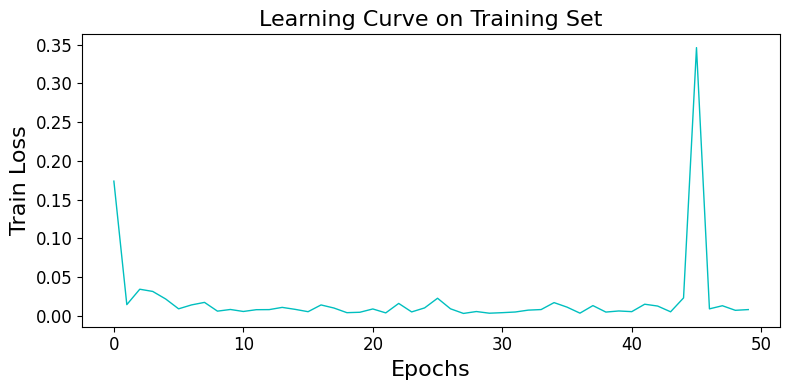

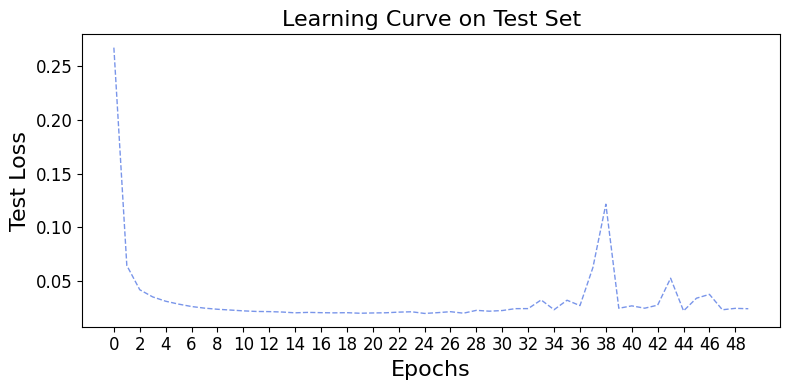

In [56]:
visLearningCurve(train_loss_log, test_loss_log)

### Calculate $R^2$ and MAE

In [57]:
import torch

# Assuming `model` is your PyTorch model
# Assuming `train_loader` and `test_loader` are your data loaders for training and test sets

def calculate_mae(model, data_loader):
    model.eval()
    total_mae = 0.0
    n_samples = 0

    with torch.no_grad():
        for x, y in data_loader:
            if torch.cuda.is_available():
               x, y = x.cuda(), y.cuda()
            pred_y = model(x)
            mae = torch.abs(pred_y - y).mean()
            total_mae += mae * x.size(0)
            n_samples += x.size(0)

    mean_mae = total_mae / n_samples
    return mean_mae.item()

def calculate_r2(model, data_loader,train_loader):
    model.eval()
    total_sst = 0.0
    total_ssr = 0.0
    n_samples = 0

    # Compute the mean of the y over the entire dataset
    y_mean = torch.cat([y for _, y in train_loader]).mean()
    with torch.no_grad():
        for x, y in data_loader:
            if torch.cuda.is_available():
               x, y = x.cuda(), y.cuda()
            pred_y = model(x)
            sst = torch.pow(y - y_mean, 2).sum()
            ssr = torch.pow(pred_y - y, 2).sum()
            total_sst += sst
            total_ssr += ssr
            n_samples += x.size(0)

    r_squared = 1 - (total_ssr / total_sst)
    return r_squared.item()

In [58]:
# Define Test Loader here
test_dataset = CustomDataset(ames_test_encoded)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [59]:
# Calculate MAE and R² for training set
train_mae_lr_torch = calculate_mae(lr_reg, train_loader)
train_r2_lr_torch = calculate_r2(lr_reg, train_loader,train_loader)

# Calculate MAE and R² for test set
test_mae_lr_torch = calculate_mae(lr_reg, test_loader)
test_r2_lr_torch = calculate_r2(lr_reg, test_loader,train_loader)

print(f"Training MAE: {train_mae_lr_torch}, Training R²: {train_r2_lr_torch}")
print(f"Test MAE: {test_mae_lr_torch}, Test R²: {test_r2_lr_torch}")

Training MAE: 0.07659909129142761, Training R²: 0.9270163774490356
Test MAE: 0.0983048528432846, Test R²: 0.8597171902656555


### Comparison with Statsmodels

In [60]:
import statsmodels.formula.api as smf
all_columns = "+".join(ames_train.columns.difference(["LogSalePrice"]))
my_formula = "LogSalePrice~" + all_columns +'-1'
print(my_formula)

mod_naive = smf.ols(my_formula, data=ames_train)
nlr = mod_naive.fit()

print(nlr.summary())

LogSalePrice~Alley+Artery+AsbShng+AsphShn+BedroomAbvGr+BldgType+BrkCmn+BrkComm+BrkFace+BsmtCond+BsmtExposure+BsmtFinSF1+BsmtFinSF2+BsmtFinType1+BsmtFinType2+BsmtFullBath+BsmtHalfBath+BsmtQual+BsmtUnfSF+CBlock+CemntBd+CentralAir+CmentBd+Electrical+EnclosedPorch+ExterCond+ExterQual+Feedr+Fence+FireplaceQu+Fireplaces+Foundation+FullBath+Functional+GarageArea+GarageCars+GarageCond+GarageFinish+GarageQual+GarageType+GrLivArea+HalfBath+HdBoard+Heating+HeatingQC+HouseStyle+ImStucc+KitchenAbvGr+KitchenQual+LandContour+LandSlope+LotArea+LotConfig+LotFrontage+LotShape+LowQualFinSF+MSSubClass+MSZoning+MasVnrArea+MasVnrType+MetalSd+MiscVal+MoSold+Neighborhood+Norm+OpenPorchSF+Other+OverallCond+OverallQual+PavedDrive+Plywood+PoolArea+PoolQC+PosA+PosN+PreCast+RRAe+RRAn+RRNe+RRNn+RoofMatl+RoofStyle+SaleCondition+SaleType+ScreenPorch+Stone+Street+Stucco+TotRmsAbvGrd+TotalBsmtSF+Utilities+VinylSd+WdSdng+WdShing+WdShng+WoodDeckSF+X1stFlrSF+X2ndFlrSF+X3SsnPorch+YearsSince1950Built+YearsSince1950GarageBui

In [61]:
def OSR2(y_train, y_test, y_pred):

    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)

    return (1 - SSE/SST)

def MAE(y_test, y_pred):

    return (np.mean(abs(y_test - y_pred)))

def print_metrics(model, X_train, y_train, X_test, y_test, flag_log_sale_price=False):

    if (flag_log_sale_price == True):

        y_pred_train = pd.Series(model.predict(X_train)).reset_index(drop=True)
        y_pred_test = pd.Series(model.predict(X_test)).reset_index(drop=True)
        y_train = y_train.copy().reset_index(drop=True)
        y_test = y_test.copy().reset_index(drop=True)

        print("\nMetrics for Log(Sale Price):\n")

    elif (flag_log_sale_price == False):

        y_pred_train = pd.Series(model.predict(X_train)).apply(np.exp).reset_index(drop=True)
        y_pred_test = pd.Series(model.predict(X_test)).apply(np.exp).reset_index(drop=True)
        y_train = y_train.copy().apply(np.exp).reset_index(drop=True)
        y_test = y_test.copy().apply(np.exp).reset_index(drop=True)

        print("\nMetrics for Sale Price:\n")
    train_r2 = OSR2(y_train, y_train, y_pred_train)
    train_mae = MAE(y_train, y_pred_train)
    print('Training R2', train_r2)
    print('Training MAE', train_mae)

    test_r2 = OSR2(y_train, y_test, y_pred_test)
    test_mae = MAE(y_test, y_pred_test)
    print('Out-of-sample R2', test_r2)
    print('Out-of-sample MAE', test_mae)

    return train_r2, train_mae, test_r2, test_mae

In [62]:
y_train_sm = ames_train.iloc[:,0]
y_test_sm = ames_test.iloc[:,0]
train_r2_sm, train_mae_sm, test_r2_sm, test_mae_sm = print_metrics(nlr, ames_train, y_train_sm, ames_test, y_test_sm, flag_log_sale_price = True)


Metrics for Log(Sale Price):

Training R2 0.959221645198579
Training MAE 0.058109081016711514
Out-of-sample R2 0.8279251420930871
Out-of-sample MAE 0.08941158498741186


## "Common Sense" Linear Regression

We want to perform linear regression with only some of the variables which could be chosen using common sense

In [63]:
ames = pd.read_csv('Ames_cleaned.csv')
ames_cs = ames[['LogSalePrice','MSSubClass', 'OverallQual','YearsSince1950Built','GrLivArea','TotRmsAbvGrd','FullBath','SaleCondition','YrSold']]

# This is used to be int type columns
discrete_cols = ['MSSubClass']
ames_cs[discrete_cols] = ames_cs[discrete_cols].astype('int').astype('category')

# Change remaining categorical variable types into 'category' type
still_categorical = ames_cs.columns[ames_cs.dtypes == 'object']
ames_cs[still_categorical] = ames_cs[still_categorical].astype('category')


<ipython-input-63-86a8f5071d68>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ames_cs[discrete_cols] = ames_cs[discrete_cols].astype('int').astype('category')
<ipython-input-63-86a8f5071d68>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ames_cs[still_categorical] = ames_cs[still_categorical].astype('category')


In [64]:
ames_cs.head(5)

,LogSalePrice,MSSubClass,OverallQual,YearsSince1950Built,GrLivArea,TotRmsAbvGrd,FullBath,SaleCondition,YrSold
0,12.278393,20,6,10,1656.0,7,1,Normal,2010
1,11.561716,20,5,11,896.0,5,1,Normal,2010
2,12.055250,20,6,8,1329.0,6,1,Normal,2010
3,12.404924,20,7,18,2110.0,8,2,Normal,2010
4,12.154253,60,5,47,1629.0,6,2,Normal,2010


In [65]:
# Dummy Encoding
ames_cs_encoded = pd.get_dummies(ames_cs.select_dtypes(include=['category']))
ames_cs_encoded = pd.concat([ames_cs.select_dtypes(exclude=['category']),ames_cs_encoded],axis=1)

# Scale our data: Scaling is actually important when using SGD based optimizer. We will see the effect later.

# # Select columns with dtype float
cols = ames_cs_encoded.select_dtypes(include=['float','int']).columns

# Exclude 'LogSalePrice' and 'YrSold' from the list
cols = [item for item in cols if item != "LogSalePrice" and item !="YrSold"]

# Devide the data into training and the test set
ames_cs_train_encoded = ames_cs_encoded.loc[ames_cs_encoded['YrSold'].isin([2006, 2007, 2008])]
ames_cs_test_encoded = ames_cs_encoded.loc[ames_cs_encoded['YrSold'].isin([2009, 2010])]

# Which we will be using later using statsmodel pkg
ames_cs_train = ames_cs.loc[ames_cs['YrSold'].isin([2006, 2007, 2008])]
ames_cs_test = ames_cs.loc[ames_cs['YrSold'].isin([2009, 2010])]

# Standardization
scaler = StandardScaler()
ames_cs_train_encoded[cols] = scaler.fit_transform(ames_cs_train_encoded[cols])

# Use the same scaler to transform the test data
ames_cs_test_encoded[cols] = scaler.transform(ames_cs_test_encoded[cols])

# Drop 'YrSold' column as it is no longer needed
for df in [ames_cs_encoded, ames_cs_train_encoded, ames_cs_test_encoded, ames_cs, ames_cs_train, ames_cs_test]:
    df.drop(columns=['YrSold'], inplace=True)

print(ames_cs.shape, ames_cs_train.shape, ames_cs_test.shape)

(2924, 8) (1935, 8) (989, 8)


<ipython-input-65-ef7337757e30>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ames_cs_train_encoded[cols] = scaler.fit_transform(ames_cs_train_encoded[cols])
<ipython-input-65-ef7337757e30>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ames_cs_test_encoded[cols] = scaler.transform(ames_cs_test_encoded[cols])
<ipython-input-65-ef7337757e30>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pa

In [66]:
cs_train_dataset = CustomDataset(ames_cs_train_encoded)
# Define a DataLoader
cs_train_loader = DataLoader(cs_train_dataset, batch_size=32, shuffle=True)

cs_test_dataset = CustomDataset(ames_cs_test_encoded)
# Define a DataLoader
cs_test_loader = DataLoader(cs_test_dataset, batch_size=32, shuffle=True)

x_cs_test = torch.tensor(ames_cs_test_encoded.iloc[:, 1:].values.astype(float), dtype=torch.float32)
y_cs_test = torch.tensor(ames_cs_test_encoded.iloc[:,0], dtype=torch.float32).view(-1,1)

In [67]:
num_cs_features = ames_cs_train_encoded.shape[1] - 1
num_items = 1 # we are predicting LogSalePrice
# prediction model
class CS_LinearRegression(nn.Module): # The class should inherit nn.Module class

    def __init__(self):
        super(CS_LinearRegression, self).__init__()
        self.linear = nn.Linear(num_cs_features, num_items) # Define a linear layer. A single layer NN is equivalent to linear regression model.
        # Notice that there is no any other hidden layer on this model.

    # forward function must be defined in our model. Due to the nn.module property calling LinearRegression(x) would run the forward pass.
    def forward(self, x):
        out = self.linear(x) # linear regression
        return out

In [68]:
cs_lr_reg = CS_LinearRegression()
learning_rate = 1e-2
optimizer = torch.optim.Adam(cs_lr_reg.parameters(), lr=learning_rate) # parameters() method is inherited from nn.Module
# optimizer = torch.optim.SGD(cs_lr_reg.parameters(), lr= learning_rate)
loss_func = nn.MSELoss()  # Mean squared error loss
num_epochs = 50
train_loss_log, test_loss_log = train_model(cs_lr_reg, loss_func, num_epochs, optimizer, cs_train_loader, x_cs_test, y_cs_test)

Epoch  1,  Training Loss:  109.2439,  Test Loss: 106.4054
Epoch  2,  Training Loss:   77.9822,  Test Loss: 76.3284
Epoch  3,  Training Loss:   55.5331,  Test Loss: 53.3663
Epoch  4,  Training Loss:   35.2513,  Test Loss: 36.2013
Epoch  5,  Training Loss:   26.7524,  Test Loss: 23.8369
Epoch  6,  Training Loss:   14.3772,  Test Loss: 15.1867
Epoch  7,  Training Loss:   10.2762,  Test Loss:  9.3646
Epoch  8,  Training Loss:    6.8302,  Test Loss:  5.5848
Epoch  9,  Training Loss:    3.4465,  Test Loss:  3.2366
Epoch 10,  Training Loss:    1.3609,  Test Loss:  1.8358
Epoch 11,  Training Loss:    1.3884,  Test Loss:  1.0363
Epoch 12,  Training Loss:    0.6889,  Test Loss:  0.5948
Epoch 13,  Training Loss:    0.3422,  Test Loss:  0.3628
Epoch 14,  Training Loss:    0.1264,  Test Loss:  0.2390
Epoch 15,  Training Loss:    0.1963,  Test Loss:  0.1757
Epoch 16,  Training Loss:    0.3722,  Test Loss:  0.1410
Epoch 17,  Training Loss:    0.0576,  Test Loss:  0.1188
Epoch 18,  Training Loss:    0

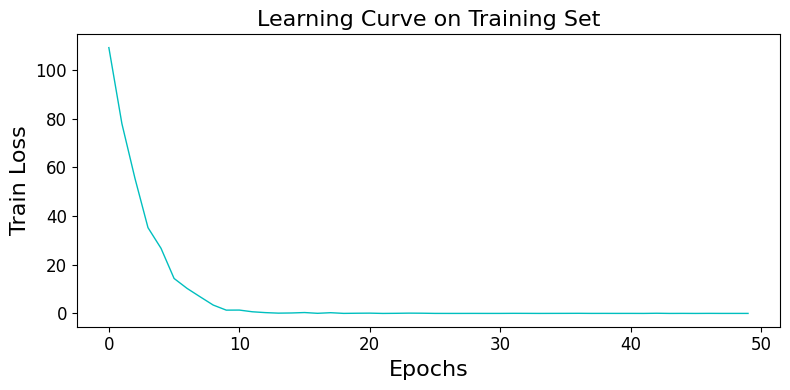

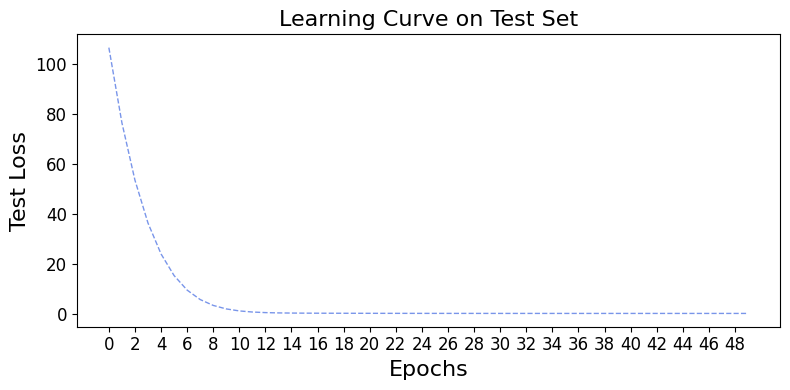

In [69]:
visLearningCurve(train_loss_log, test_loss_log)

In [70]:
# Calculate MAE and R² for training set
cs_train_mae_lr_torch = calculate_mae(cs_lr_reg, cs_train_loader)
cs_train_r2_lr_torch = calculate_r2(cs_lr_reg, cs_train_loader,cs_train_loader)

# Calculate MAE and R² for test set
cs_test_mae_lr_torch = calculate_mae(cs_lr_reg, cs_test_loader)
cs_test_r2_lr_torch = calculate_r2(cs_lr_reg, cs_test_loader,cs_train_loader)

print(f"Training MAE: {cs_train_mae_lr_torch}, Training R²: {cs_train_r2_lr_torch}")
print(f"Test MAE: {cs_test_mae_lr_torch}, Test R²: {cs_test_r2_lr_torch}")

Training MAE: 0.11164923757314682, Training R²: 0.8499791026115417
Test MAE: 0.1197635680437088, Test R²: 0.8313799500465393


Comparison with StatsModel

In [71]:
all_columns = "+".join(ames_cs_train.columns.difference(["LogSalePrice"]))
my_formula = "LogSalePrice~" + all_columns +'-1'
print(my_formula)

cs_mod_naive = smf.ols(my_formula, data=ames_cs_train)
cs_nlr = cs_mod_naive.fit()

print(cs_nlr.summary())

LogSalePrice~FullBath+GrLivArea+MSSubClass+OverallQual+SaleCondition+TotRmsAbvGrd+YearsSince1950Built-1
                            OLS Regression Results                            
Dep. Variable:           LogSalePrice   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     459.8
Date:                Mon, 17 Mar 2025   Prob (F-statistic):               0.00
Time:                        22:22:24   Log-Likelihood:                 908.40
No. Observations:                1935   AIC:                            -1765.
Df Residuals:                    1909   BIC:                            -1620.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-------------

In [72]:
y_cs_train_sm = ames_cs_train.iloc[:,0]
y_cs_test_sm = ames_cs_test.iloc[:,0]
cs_train_r2_sm, cs_train_mae_sm, cs_test_r2_sm, cs_test_mae_sm = print_metrics(cs_nlr, ames_cs_train, y_cs_train_sm, ames_cs_test, y_cs_test_sm, flag_log_sale_price = True)


Metrics for Log(Sale Price):

Training R2 0.8575872255322426
Training MAE 0.11011044891110033
Out-of-sample R2 0.8324333920161902
Out-of-sample MAE 0.11903647017345487


In [73]:
y_predict = cs_nlr.predict(ames_cs_test)
y_mean = y_cs_train_sm.mean()
SST = ((y_cs_test_sm - y_mean)**2).sum()
SSE = ((y_predict - y_cs_test_sm)**2).sum()

## Multilayer Perceptron

For MLP, we will be using smaller dataset ("common sense" dataset).


## Multiple Hidden Layer Model for Regression

In [76]:
from torch import nn

num_cs_features = ames_cs_train_encoded.shape[1] - 1
num_hidden_units = 20  # You can choose the number of units in the hidden layer
num_items = 1  # we are predicting LogSalePrice

class OneHiddenLayer(nn.Module):

    def __init__(self):
        super(OneHiddenLayer, self).__init__()
        # Define the hidden layer
        self.hidden = nn.Linear(num_cs_features, num_hidden_units)
        # Mini Exercise: Define the ReLU activation function
        self.relu = nn.ReLU() # fill in here
        # Define the output layer
        self.output = nn.Linear(num_hidden_units, num_items)

    def forward(self, x):
        # Pass the input through the hidden layer, then through ReLU, and finally through the output layer
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        return x


In [77]:
one_hidden_layer_relu = OneHiddenLayer()
learning_rate = 1e-2
optimizer = torch.optim.Adam(one_hidden_layer_relu.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(lr_reg.parameters(), lr= learning_rate)

loss_func = nn.MSELoss()  # Mean squared error loss
num_epochs = 50
train_loss_log, test_loss_log = train_model(one_hidden_layer_relu, loss_func, num_epochs, optimizer, cs_train_loader, x_cs_test, y_cs_test)

Epoch  1,  Training Loss:    5.5203,  Test Loss:  4.4774
Epoch  2,  Training Loss:    0.4719,  Test Loss:  0.2930
Epoch  3,  Training Loss:    0.1066,  Test Loss:  0.1130
Epoch  4,  Training Loss:    0.0200,  Test Loss:  0.0665
Epoch  5,  Training Loss:    0.0273,  Test Loss:  0.0504
Epoch  6,  Training Loss:    0.0217,  Test Loss:  0.0418
Epoch  7,  Training Loss:    0.0634,  Test Loss:  0.0391
Epoch  8,  Training Loss:    0.0274,  Test Loss:  0.0367
Epoch  9,  Training Loss:    0.0304,  Test Loss:  0.0350
Epoch 10,  Training Loss:    0.0240,  Test Loss:  0.0326
Epoch 11,  Training Loss:    0.0286,  Test Loss:  0.0356
Epoch 12,  Training Loss:    0.0275,  Test Loss:  0.0322
Epoch 13,  Training Loss:    0.0282,  Test Loss:  0.0313
Epoch 14,  Training Loss:    0.0180,  Test Loss:  0.0308
Epoch 15,  Training Loss:    0.0138,  Test Loss:  0.0347
Epoch 16,  Training Loss:    0.0273,  Test Loss:  0.0329
Epoch 17,  Training Loss:    0.0410,  Test Loss:  0.0325
Epoch 18,  Training Loss:    0.

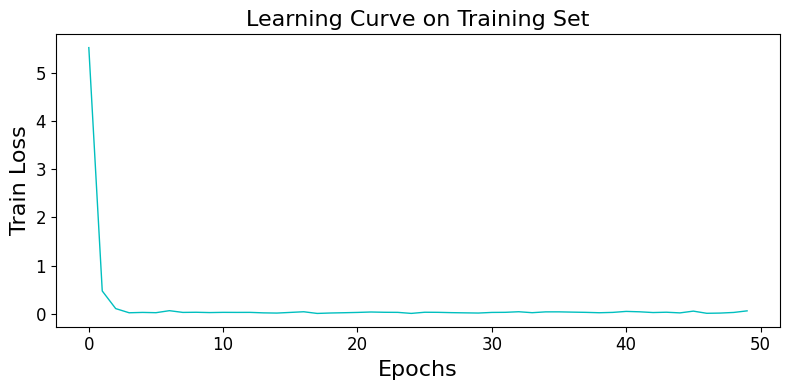

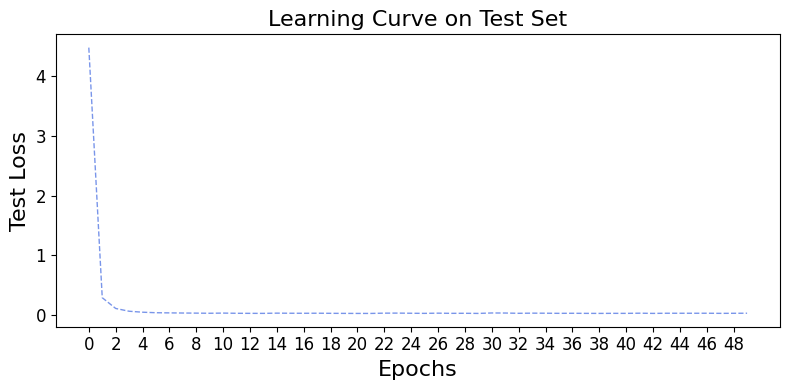

In [78]:
visLearningCurve(train_loss_log, test_loss_log)

In [79]:
# Calculate MAE and R² for training set
cs_train_mae_single_hidden_relu = calculate_mae(one_hidden_layer_relu, cs_train_loader)
cs_train_r2_single_hidden_relu = calculate_r2(one_hidden_layer_relu, cs_train_loader,cs_train_loader)

# Calculate MAE and R² for test set
cs_test_mae_single_hidden_relu = calculate_mae(one_hidden_layer_relu, cs_test_loader)
cs_test_r2_single_hidden_relu = calculate_r2(one_hidden_layer_relu, cs_test_loader,cs_train_loader)

print(f"Training MAE: {cs_train_mae_single_hidden_relu}, Training R²: {cs_train_r2_single_hidden_relu}")
print(f"Test MAE: {cs_test_mae_single_hidden_relu}, Test R²: {cs_test_r2_single_hidden_relu}")

Training MAE: 0.1205483227968216, Training R²: 0.8424989581108093
Test MAE: 0.13526466488838196, Test R²: 0.8069760799407959


Notice that our model is now non-convex function. Therefore, our model might not converge to the optimal model, even if we run large enough epoch with well-tuned step-size.

We can also try different activation functions other than ReLU: Sigmoid, Tanh, GELU, etc..

In [80]:
class OneHiddenLayerSigmoid(nn.Module):

    def __init__(self):
        super(OneHiddenLayerSigmoid, self).__init__()
        # Define the hidden layer
        self.hidden = nn.Linear(num_cs_features, num_hidden_units)
        self.relu = nn.Sigmoid()
        # Define the output layer
        self.output = nn.Linear(num_hidden_units, num_items)

    def forward(self, x):
        # Pass the input through the hidden layer, then through ReLU, and finally through the output layer
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        return x

In [81]:
one_hidden_layer_sigmoid = OneHiddenLayerSigmoid()
learning_rate = 1e-2
optimizer = torch.optim.Adam(one_hidden_layer_sigmoid.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(lr_reg.parameters(), lr= learning_rate)

loss_func = nn.MSELoss()  # Mean squared error loss
num_epochs = 50
train_loss_log, test_loss_log = train_model(one_hidden_layer_sigmoid, loss_func, num_epochs, optimizer, cs_train_loader, x_cs_test, y_cs_test)

Epoch  1,  Training Loss:   10.3661,  Test Loss:  9.2407
Epoch  2,  Training Loss:    0.0598,  Test Loss:  0.0662
Epoch  3,  Training Loss:    0.0369,  Test Loss:  0.0420
Epoch  4,  Training Loss:    0.0735,  Test Loss:  0.0367
Epoch  5,  Training Loss:    0.0222,  Test Loss:  0.0338
Epoch  6,  Training Loss:    0.0120,  Test Loss:  0.0320
Epoch  7,  Training Loss:    0.0214,  Test Loss:  0.0307
Epoch  8,  Training Loss:    0.0166,  Test Loss:  0.0301
Epoch  9,  Training Loss:    0.0180,  Test Loss:  0.0301
Epoch 10,  Training Loss:    0.0105,  Test Loss:  0.0300
Epoch 11,  Training Loss:    0.0298,  Test Loss:  0.0309
Epoch 12,  Training Loss:    0.0133,  Test Loss:  0.0306
Epoch 13,  Training Loss:    0.0174,  Test Loss:  0.0303
Epoch 14,  Training Loss:    0.0229,  Test Loss:  0.0299
Epoch 15,  Training Loss:    0.0187,  Test Loss:  0.0309
Epoch 16,  Training Loss:    0.0188,  Test Loss:  0.0298
Epoch 17,  Training Loss:    0.0240,  Test Loss:  0.0297
Epoch 18,  Training Loss:    0.

In [82]:
# Calculate MAE and R² for training set
cs_train_mae_single_hidden_sigmoid = calculate_mae(one_hidden_layer_sigmoid, cs_train_loader)
cs_train_r2_single_hidden_sigmoid = calculate_r2(one_hidden_layer_sigmoid, cs_train_loader,cs_train_loader)

# Calculate MAE and R² for test set
cs_test_mae_single_hidden_sigmoid = calculate_mae(one_hidden_layer_sigmoid, cs_test_loader)
cs_test_r2_single_hidden_sigmoid = calculate_r2(one_hidden_layer_sigmoid, cs_test_loader,cs_train_loader)

print(f"Training MAE: {cs_train_mae_single_hidden_sigmoid}, Training R²: {cs_train_r2_single_hidden_sigmoid}")
print(f"Test MAE: {cs_test_mae_single_hidden_sigmoid}, Test R²: {cs_test_r2_single_hidden_sigmoid}")

Training MAE: 0.1063433364033699, Training R²: 0.8663380146026611
Test MAE: 0.12004969269037247, Test R²: 0.8291348814964294


### Two Hidden Layer

In [83]:
from torch import nn

num_cs_features = ames_cs_train_encoded.shape[1] - 1
num_hidden_units1 = 20  # Number of units in the first hidden layer
num_hidden_units2 = 10   # Number of units in the second hidden layer
num_items = 1  # Predicting LogSalePrice

class TwoHiddenLayers(nn.Module):

    def __init__(self):
        super(TwoHiddenLayers, self).__init__()
        self.hidden1 = nn.Linear(num_cs_features, num_hidden_units1)
        self.relu1 = nn.ReLU()
        self.hidden2 = nn.Linear(num_hidden_units1, num_hidden_units2)
        self.relu2 = nn.ReLU()
        self.output = nn.Linear(num_hidden_units2, num_items)

    def forward(self, x):
        x = self.hidden1(x)
        x = self.relu1(x)
        x = self.hidden2(x)
        x = self.relu2(x)
        x = self.output(x)
        return x


In [84]:
two_hidden_layer = TwoHiddenLayers()
learning_rate = 1e-2
optimizer = torch.optim.Adam(two_hidden_layer.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(lr_reg.parameters(), lr= learning_rate)

loss_func = nn.MSELoss()  # Mean squared error loss
num_epochs = 50
train_loss_log, test_loss_log = train_model(two_hidden_layer, loss_func, num_epochs, optimizer, cs_train_loader, x_cs_test, y_cs_test)

Epoch  1,  Training Loss:    0.4947,  Test Loss:  1.1347
Epoch  2,  Training Loss:    0.0692,  Test Loss:  0.2289
Epoch  3,  Training Loss:    0.0785,  Test Loss:  0.1066
Epoch  4,  Training Loss:    0.1025,  Test Loss:  0.0718
Epoch  5,  Training Loss:    0.0154,  Test Loss:  0.0552
Epoch  6,  Training Loss:    0.1316,  Test Loss:  0.0475
Epoch  7,  Training Loss:    0.0633,  Test Loss:  0.0481
Epoch  8,  Training Loss:    0.0271,  Test Loss:  0.0408
Epoch  9,  Training Loss:    0.0243,  Test Loss:  0.0405
Epoch 10,  Training Loss:    0.0197,  Test Loss:  0.0450
Epoch 11,  Training Loss:    0.0412,  Test Loss:  0.0391
Epoch 12,  Training Loss:    0.0202,  Test Loss:  0.0369
Epoch 13,  Training Loss:    0.0207,  Test Loss:  0.0396
Epoch 14,  Training Loss:    0.0211,  Test Loss:  0.0395
Epoch 15,  Training Loss:    0.1647,  Test Loss:  0.0355
Epoch 16,  Training Loss:    0.0315,  Test Loss:  0.0377
Epoch 17,  Training Loss:    0.0206,  Test Loss:  0.0347
Epoch 18,  Training Loss:    0.

In [85]:
# Calculate MAE and R² for training set
cs_train_mae_two_hidden = calculate_mae(two_hidden_layer, cs_train_loader)
cs_train_r2_two_hidden = calculate_r2(two_hidden_layer, cs_train_loader,cs_train_loader)

# Calculate MAE and R² for test set
cs_test_mae_two_hidden = calculate_mae(two_hidden_layer, cs_test_loader)
cs_test_r2_two_hidden = calculate_r2(two_hidden_layer, cs_test_loader,cs_train_loader)

print(f"Training MAE: {cs_train_mae_two_hidden}, Training R²: {cs_train_r2_two_hidden}")
print(f"Test MAE: {cs_test_mae_two_hidden}, Test R²: {cs_test_r2_two_hidden}")

Training MAE: 0.13368187844753265, Training R²: 0.8145442605018616
Test MAE: 0.1395544558763504, Test R²: 0.7823288440704346


### Three Hidden Layer & Genralized MLP

In [86]:
from torch import nn

num_features = ames_cs_train_encoded.shape[1] - 1
num_hidden_units1 = 40  # Number of units in the first hidden layer
num_hidden_units2 = 20   # Number of units in the second hidden layer
num_hidden_units3 = 10   # Number of units in the third hidden layer
num_items = 1  # Predicting LogSalePrice

class ThreeHiddenLayers(nn.Module):

    def __init__(self):
        super(ThreeHiddenLayers, self).__init__()
        self.hidden1 = nn.Linear(num_features, num_hidden_units1)
        self.relu1 = nn.ReLU()
        self.hidden2 = nn.Linear(num_hidden_units1, num_hidden_units2)
        self.relu2 = nn.ReLU()
        self.hidden3 = nn.Linear(num_hidden_units2, num_hidden_units3)
        self.relu3 = nn.ReLU()
        self.output = nn.Linear(num_hidden_units3, num_items)

    def forward(self, x):
        x = self.hidden1(x)
        x = self.relu1(x)
        x = self.hidden2(x)
        x = self.relu2(x)
        x = self.hidden3(x)
        x = self.relu3(x)
        x = self.output(x)
        return x


In [87]:
three_hidden_layer = ThreeHiddenLayers()
learning_rate = 1e-2
optimizer = torch.optim.Adam(three_hidden_layer.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(lr_reg.parameters(), lr= learning_rate)

loss_func = nn.MSELoss()  # Mean squared error loss
num_epochs = 50
train_loss_log, test_loss_log = train_model(three_hidden_layer, loss_func, num_epochs, optimizer, cs_train_loader, x_cs_test, y_cs_test)

Epoch  1,  Training Loss:    1.4024,  Test Loss:  1.3314
Epoch  2,  Training Loss:    0.1720,  Test Loss:  0.1261
Epoch  3,  Training Loss:    0.0231,  Test Loss:  0.0713
Epoch  4,  Training Loss:    0.0360,  Test Loss:  0.0539
Epoch  5,  Training Loss:    0.0415,  Test Loss:  0.0408
Epoch  6,  Training Loss:    0.0738,  Test Loss:  0.0395
Epoch  7,  Training Loss:    0.0125,  Test Loss:  0.0371
Epoch  8,  Training Loss:    0.0467,  Test Loss:  0.0353
Epoch  9,  Training Loss:    0.0257,  Test Loss:  0.0346
Epoch 10,  Training Loss:    0.0158,  Test Loss:  0.0342
Epoch 11,  Training Loss:    0.0409,  Test Loss:  0.0369
Epoch 12,  Training Loss:    0.0473,  Test Loss:  0.0336
Epoch 13,  Training Loss:    0.0312,  Test Loss:  0.0385
Epoch 14,  Training Loss:    0.0226,  Test Loss:  0.0424
Epoch 15,  Training Loss:    0.0148,  Test Loss:  0.0347
Epoch 16,  Training Loss:    0.0142,  Test Loss:  0.0428
Epoch 17,  Training Loss:    0.0177,  Test Loss:  0.0327
Epoch 18,  Training Loss:    0.

In [88]:
# Calculate MAE and R² for training set
cs_train_mae_three_hidden = calculate_mae(three_hidden_layer, cs_train_loader)
cs_train_r2_three_hidden = calculate_r2(three_hidden_layer, cs_train_loader,cs_train_loader)

# Calculate MAE and R² for test set
cs_test_mae_three_hidden = calculate_mae(three_hidden_layer, cs_test_loader)
cs_test_r2_three_hidden = calculate_r2(three_hidden_layer, cs_test_loader,cs_train_loader)

print(f"Training MAE: {cs_train_mae_three_hidden}, Training R²: {cs_train_r2_three_hidden}")
print(f"Test MAE: {cs_test_mae_three_hidden}, Test R²: {cs_test_r2_three_hidden}")

Training MAE: 0.15555411577224731, Training R²: 0.7604111433029175
Test MAE: 0.1630389243364334, Test R²: 0.7332775592803955


We can also generalize our code to $d$-hidden layer

In [89]:
class GeneralizedMLP(nn.Module):
    def __init__(self, num_features, layer_sizes:list):
        super(GeneralizedMLP, self).__init__()
        layers = []
        input_size = num_features

        # Create hidden layers
        for size in layer_sizes:
            layers.append(nn.Linear(input_size, size))
            layers.append(nn.ReLU())
            input_size = size

        # Create output layer
        layers.append(nn.Linear(input_size, 1))  # Assuming 1 output unit

        # Store all layers in ModuleList
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [90]:
num_features = ames_cs_train_encoded.shape[1] - 1
layer_sizes = [40, 20, 10, 10]  # Four hidden layers with 40, 20, 10, and 10 units
gen_mlp = GeneralizedMLP(num_features, layer_sizes)
learning_rate = 1e-2
optimizer = torch.optim.Adam(gen_mlp.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(lr_reg.parameters(), lr= learning_rate)

loss_func = nn.MSELoss()  # Mean squared error loss
num_epochs = 50
train_loss_log, test_loss_log = train_model(gen_mlp, loss_func, num_epochs, optimizer, cs_train_loader, x_cs_test, y_cs_test)

Epoch  1,  Training Loss:    0.9030,  Test Loss:  0.8449
Epoch  2,  Training Loss:    0.0488,  Test Loss:  0.0781
Epoch  3,  Training Loss:    0.0320,  Test Loss:  0.0474
Epoch  4,  Training Loss:    0.0221,  Test Loss:  0.0449
Epoch  5,  Training Loss:    0.0199,  Test Loss:  0.0360
Epoch  6,  Training Loss:    0.0416,  Test Loss:  0.0340
Epoch  7,  Training Loss:    0.0268,  Test Loss:  0.0332
Epoch  8,  Training Loss:    0.0194,  Test Loss:  0.0349
Epoch  9,  Training Loss:    0.0227,  Test Loss:  0.0323
Epoch 10,  Training Loss:    0.0375,  Test Loss:  0.0374
Epoch 11,  Training Loss:    0.0193,  Test Loss:  0.0292
Epoch 12,  Training Loss:    0.0237,  Test Loss:  0.0306
Epoch 13,  Training Loss:    0.0462,  Test Loss:  0.0370
Epoch 14,  Training Loss:    0.0220,  Test Loss:  0.0380
Epoch 15,  Training Loss:    0.0511,  Test Loss:  0.0372
Epoch 16,  Training Loss:    0.0954,  Test Loss:  0.0460
Epoch 17,  Training Loss:    0.0411,  Test Loss:  0.0588
Epoch 18,  Training Loss:    0.

## Performance Comparison

In [91]:
import pandas as pd

# Assuming all the variables for test and training metrics are available in your environment

# Data for Ames.csv
ames_data = {
    ("Ames", "lr_torch"): {"Train MAE": train_mae_lr_torch, "Train R2": train_r2_lr_torch, "Test MAE": test_mae_lr_torch, "Test R2": test_r2_lr_torch},
    ("Ames", "lr_sm"): {"Train MAE": train_mae_sm, "Train R2": train_r2_sm, "Test MAE": test_mae_sm, "Test R2": test_r2_sm}
}

# Data for Ames Common Sense
ames_cs_data = {
    ("Ames Common Sense", "lr_torch"): {"Train MAE": cs_train_mae_lr_torch, "Train R2": cs_train_r2_lr_torch, "Test MAE": cs_test_mae_lr_torch, "Test R2": cs_test_r2_lr_torch},
    ("Ames Common Sense", "lr_sm"): {"Train MAE": cs_train_mae_sm, "Train R2": cs_train_r2_sm, "Test MAE": cs_test_mae_sm, "Test R2": cs_test_r2_sm},
    ("Ames Common Sense", "single_hidden_relu"): {"Train MAE": cs_train_mae_single_hidden_relu, "Train R2": cs_train_r2_single_hidden_relu, "Test MAE": cs_test_mae_single_hidden_relu, "Test R2": cs_test_r2_single_hidden_relu},
    ("Ames Common Sense", "single_hidden_sigmoid"): {"Train MAE": cs_train_mae_single_hidden_sigmoid, "Train R2": cs_train_r2_single_hidden_sigmoid, "Test MAE": cs_test_mae_single_hidden_sigmoid, "Test R2": cs_test_r2_single_hidden_sigmoid},
    ("Ames Common Sense", "two_hidden"): {"Train MAE": cs_train_mae_two_hidden, "Train R2": cs_train_r2_two_hidden, "Test MAE": cs_test_mae_two_hidden, "Test R2": cs_test_r2_two_hidden},
    ("Ames Common Sense", "three_hidden"): {"Train MAE": cs_train_mae_three_hidden, "Train R2": cs_train_r2_three_hidden, "Test MAE": cs_test_mae_three_hidden, "Test R2": cs_test_r2_three_hidden}
}

# Combine both datasets
all_data = {**ames_data, **ames_cs_data}

# Create a pandas DataFrame
df_comparison = pd.DataFrame(all_data)
df_comparison



Ames           Ames Common Sense                               \
           lr_torch     lr_sm          lr_torch     lr_sm single_hidden_relu   
Train MAE  0.076599  0.058109          0.111649  0.110110           0.120548   
Train R2   0.927016  0.959222          0.849979  0.857587           0.842499   
Test MAE   0.098305  0.089412          0.119764  0.119036           0.135265   
Test R2    0.859717  0.827925          0.831380  0.832433           0.806976   

                                                         
          single_hidden_sigmoid two_hidden three_hidden  
Train MAE              0.106343   0.133682     0.155554  
Train R2               0.866338   0.814544     0.760411  
Test MAE               0.120050   0.139554     0.163039  
Test R2                0.829135   0.782329     0.733278

# Classification



Instead of building a regression model on LogSalePrice, we would like to build a classifier that predicts whether the LogSalePrice would be greater than 12.0

In [92]:
# Use Common sense dataset from Ames

ames = pd.read_csv('Ames_cleaned.csv')
ames_cs = ames[['LogSalePrice','MSSubClass', 'OverallQual','YearsSince1950Built','GrLivArea','TotRmsAbvGrd','FullBath','SaleCondition','YrSold']]

<Axes: >

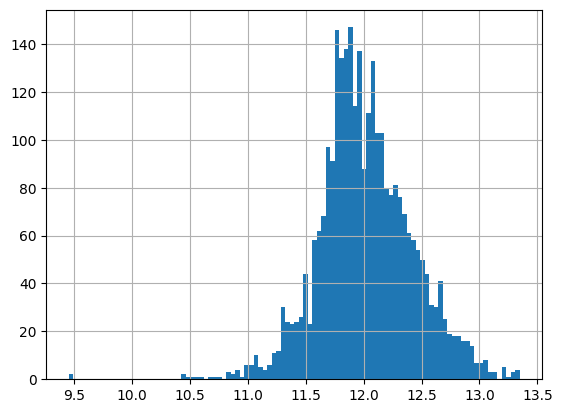

In [93]:
ames_cs['LogSalePrice'].hist(bins=100)

In [94]:
ames_cs['HighPrice'] = ames_cs['LogSalePrice'].apply(lambda x: 1 if x >12.0 else 0)
ames_cs.drop('LogSalePrice', axis=1, inplace=True)
ames_cs

<ipython-input-94-ed7c0910c67b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ames_cs['HighPrice'] = ames_cs['LogSalePrice'].apply(lambda x: 1 if x >12.0 else 0)
<ipython-input-94-ed7c0910c67b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ames_cs.drop('LogSalePrice', axis=1, inplace=True)


,MSSubClass,OverallQual,YearsSince1950Built,GrLivArea,TotRmsAbvGrd,FullBath,SaleCondition,YrSold,HighPrice
0,20,6,10,1656.0,7,1,Normal,2010,1
1,20,5,11,896.0,5,1,Normal,2010,0
2,20,6,8,1329.0,6,1,Normal,2010,1
3,20,7,18,2110.0,8,2,Normal,2010,1
4,60,5,47,1629.0,6,2,Normal,2010,1
...,...,...,...,...,...,...,...,...,...
2919,80,6,34,1003.0,6,1,Normal,2006,0
2920,20,5,33,902.0,5,1,Normal,2006,0
2921,85,5,42,970.0,6,1,Normal,2006,0
2922,20,5,24,1389.0,6,1,Normal,2006,1


In [95]:
# Create a new list of columns with the last column moved to the first position
cols = ames_cs.columns.tolist()  # Convert the column index to a list
last_col = cols.pop()  # Remove the last column from the list
cols.insert(0, last_col)  # Insert the last column at the first position
ames_cs = ames_cs[cols]
ames_cs

,HighPrice,MSSubClass,OverallQual,YearsSince1950Built,GrLivArea,TotRmsAbvGrd,FullBath,SaleCondition,YrSold
0,1,20,6,10,1656.0,7,1,Normal,2010
1,0,20,5,11,896.0,5,1,Normal,2010
2,1,20,6,8,1329.0,6,1,Normal,2010
3,1,20,7,18,2110.0,8,2,Normal,2010
4,1,60,5,47,1629.0,6,2,Normal,2010
...,...,...,...,...,...,...,...,...,...
2919,0,80,6,34,1003.0,6,1,Normal,2006
2920,0,20,5,33,902.0,5,1,Normal,2006
2921,0,85,5,42,970.0,6,1,Normal,2006
2922,1,20,5,24,1389.0,6,1,Normal,2006


In [96]:
ames_cs['HighPrice'].value_counts()

,count
HighPrice,
0,1494
1,1430


In [97]:
# This is used to be int type columns
discrete_cols = ['MSSubClass']
ames_cs[discrete_cols] = ames_cs[discrete_cols].astype('int').astype('category')

# Change remaining categorical variable types into 'category' type
still_categorical = ames_cs.columns[ames_cs.dtypes == 'object']
ames_cs[still_categorical] = ames_cs[still_categorical].astype('category')

# Dummy Encoding
ames_cs_encoded = pd.get_dummies(ames_cs.select_dtypes(include=['category']))
ames_cs_encoded = pd.concat([ames_cs.select_dtypes(exclude=['category']),ames_cs_encoded],axis=1)
# Scale our data: Scaling is actually important when using SGD based optimizer. We will see the effect later.

# Devide the data into training, validation and the test set
ames_cs_train_encoded = ames_cs_encoded.loc[ames_cs_encoded['YrSold'].isin([2006, 2007])]
ames_cs_val_encoded = ames_cs_encoded.loc[ames_cs_encoded['YrSold'].isin([2008])]
ames_cs_test_encoded = ames_cs_encoded.loc[ames_cs_encoded['YrSold'].isin([2009, 2010])]


# # Select columns with dtype float
cols = ames_cs_train_encoded.select_dtypes(include=['float','int']).columns

# Exclude 'HighPrice' and 'YrSold' from the list
cols = [item for item in cols if item != "HighPrice" and item !="YrSold"]

# Standardization
scaler = StandardScaler()
ames_cs_train_encoded[cols] = scaler.fit_transform(ames_cs_train_encoded[cols])
ames_cs_val_encoded[cols] = scaler.transform(ames_cs_val_encoded[cols])
ames_cs_test_encoded[cols] = scaler.transform(ames_cs_test_encoded[cols])

# Change boolean type to int type
bool_cols = ames_cs_train_encoded.select_dtypes(include=['bool']).columns
ames_cs_train_encoded[bool_cols] = ames_cs_train_encoded[bool_cols].astype('int')
ames_cs_val_encoded[bool_cols] = ames_cs_val_encoded[bool_cols].astype('int')
ames_cs_test_encoded[bool_cols] = ames_cs_test_encoded[bool_cols].astype('int')


# Which we will be using later using statsmodel pkg
ames_cs_train = ames_cs.loc[ames_cs['YrSold'].isin([2006, 2007])]
ames_cs_val = ames_cs.loc[ames_cs['YrSold'].isin([2008])]
ames_cs_test = ames_cs.loc[ames_cs['YrSold'].isin([2009, 2010])]

ames_cs_encoded.drop(columns = ['YrSold'], inplace=True)
ames_cs_train_encoded.drop(columns = ['YrSold'], inplace=True)
ames_cs_val_encoded.drop(columns = ['YrSold'], inplace=True)
ames_cs_test_encoded.drop(columns = ['YrSold'], inplace=True)

ames_cs.drop(columns = ['YrSold'], inplace=True)
ames_cs_train.drop(columns = ['YrSold'], inplace=True)
ames_cs_val.drop(columns = ['YrSold'], inplace=True)
ames_cs_test.drop(columns = ['YrSold'], inplace=True)

print(ames_cs.shape, ames_cs_train.shape, ames_cs_val.shape, ames_cs_test.shape)

(2924, 8) (1314, 8) (621, 8) (989, 8)


<ipython-input-97-2e855abbb437>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ames_cs_train_encoded[cols] = scaler.fit_transform(ames_cs_train_encoded[cols])
<ipython-input-97-2e855abbb437>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ames_cs_val_encoded[cols] = scaler.transform(ames_cs_val_encoded[cols])
<ipython-input-97-2e855abbb437>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [98]:
cs_train_dataset = CustomDataset(ames_cs_train_encoded)
# Define a DataLoader
cs_train_loader = DataLoader(cs_train_dataset, batch_size=64, shuffle=True)

cs_val_dataset = CustomDataset(ames_cs_val_encoded)
# Define a DataLoader
cs_val_loader = DataLoader(cs_val_dataset, batch_size=64, shuffle=True)

cs_test_dataset = CustomDataset(ames_cs_test_encoded)
# Define a DataLoader
cs_test_loader = DataLoader(cs_test_dataset, batch_size=64, shuffle=True)

x_cs_val = torch.tensor(ames_cs_val_encoded.iloc[:, 1:].values, dtype=torch.float32)
y_cs_val = torch.tensor(ames_cs_val_encoded.iloc[:,0].values, dtype=torch.float32).view(-1,1)
x_cs_test = torch.tensor(ames_cs_test_encoded.iloc[:, 1:].values, dtype=torch.float32)
y_cs_test = torch.tensor(ames_cs_test_encoded.iloc[:,0].values, dtype=torch.float32).view(-1,1)

print(x_cs_val.shape, y_cs_val.shape, x_cs_test.shape, y_cs_test.shape)

torch.Size([621, 27]) torch.Size([621, 1]) torch.Size([989, 27]) torch.Size([989, 1])


We will be using training set to train our models and validation set to choose the final model.
We measure the final model's performance on the test set.

# Classification: Logistic Regression in Pytorch

In [99]:
# Build Logistic Regression Model in Pytorch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        out = self.linear(x)
        return F.sigmoid(out)

In [100]:
# Visualize the learning curve
from sklearn.metrics import accuracy_score, confusion_matrix
from matplotlib import pyplot as plt

def visLearningCurve(train_loss_log, test_loss_log):
    # create figure and subplot for training loss
    fig1, ax1 = plt.subplots(figsize=(8, 4))
    ax1.plot(train_loss_log, color="c", lw=1)
    ax1.tick_params(axis="both", which="major", labelsize=12)
    ax1.set_xlabel("Epochs", fontsize=16)
    ax1.set_ylabel("Train Loss", fontsize=16)
    ax1.set_title("Learning Curve on Training Set", fontsize=16)
    fig1.tight_layout()
    # fig1.savefig("train_loss_curve.png")

    # create figure and subplot for test loss
    fig2, ax2 = plt.subplots(figsize=(8, 4))
    ax2.plot(test_loss_log, color="royalblue", ls="--", alpha=0.7, lw=1)
    ax2.set_xticks(range(0, len(test_loss_log),5))
    ax2.tick_params(axis="both", which="major", labelsize=12)
    ax2.set_xlabel("Epochs", fontsize=16)
    ax2.set_ylabel("Test Loss", fontsize=16)
    ax2.set_title("Learning Curve on Test Set", fontsize=16)
    fig2.tight_layout()
    # fig2.savefig("test_loss_curve.png")

    # Optionally display the plots
    plt.show()

# For torch models, we need to define a function to calculate the metrics
# Calculate metrics for binary classification (using Cross Entropy Loss)
def calculate_metrics_with_CEL(model, x, y):
    model.eval()
    with torch.no_grad():
        y_prob = model(x)
        y_pred = torch.argmax(y_prob, dim=1)
        acc = accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())
        tn, fp, fn, tp = confusion_matrix(y.cpu().numpy(), y_pred.cpu().numpy()).ravel()
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        print(f"Accuracy: {acc:.4f}, TPR: {tpr:.4f}, FPR: {fpr:.4f}")
    return acc, tpr, fpr

# Calculate metrics for binary classification (using Binary Cross Entropy)
def calculate_metrics_with_BCE(model,x,y):
    model.eval()
    with torch.no_grad():
        y_prob = model(x)
        y_pred = (y_prob > 0.5).float()
        acc = accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())
        tn, fp, fn, tp = confusion_matrix(y.cpu().numpy(), y_pred.cpu().numpy()).ravel()
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        print(f"Accuracy: {acc:.4f}, TPR: {tpr:.4f}, FPR: {fpr:.4f}")
    return acc, tpr, fpr

# Define similar function for statmodels
def calculate_metrics_no_torch(model, x, y):
    y_prob = model.predict(x)
    y_pred = (y_prob > 0.5).astype(int)
    acc = accuracy_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    print(f"Accuracy: {acc:.4f}, TPR: {tpr:.4f}, FPR: {fpr:.4f}")
    return acc, tpr, fpr


In [101]:
# Define the model and the optimizer
log_reg_torch = LogisticRegression(ames_cs_train_encoded.shape[1]-1)
learning_rate = 5e-3
optimizer = torch.optim.Adam(log_reg_torch.parameters(), lr=learning_rate)

# Train model

# Define the loss function: BCELoss
loss_func = nn.BCELoss()
num_epochs = 50
train_loss_log, test_loss_log = train_model(log_reg_torch, loss_func, num_epochs, optimizer, cs_train_loader, x_cs_val, y_cs_val)

Epoch  1,  Training Loss:    0.4912,  Test Loss:  0.5170
Epoch  2,  Training Loss:    0.4923,  Test Loss:  0.4395
Epoch  3,  Training Loss:    0.5023,  Test Loss:  0.3917
Epoch  4,  Training Loss:    0.3416,  Test Loss:  0.3607
Epoch  5,  Training Loss:    0.4606,  Test Loss:  0.3389
Epoch  6,  Training Loss:    0.2436,  Test Loss:  0.3230
Epoch  7,  Training Loss:    0.2158,  Test Loss:  0.3112
Epoch  8,  Training Loss:    0.3817,  Test Loss:  0.3021
Epoch  9,  Training Loss:    0.3038,  Test Loss:  0.2947
Epoch 10,  Training Loss:    0.2349,  Test Loss:  0.2887
Epoch 11,  Training Loss:    0.2750,  Test Loss:  0.2843
Epoch 12,  Training Loss:    0.3039,  Test Loss:  0.2805
Epoch 13,  Training Loss:    0.2477,  Test Loss:  0.2768
Epoch 14,  Training Loss:    0.1983,  Test Loss:  0.2743
Epoch 15,  Training Loss:    0.3167,  Test Loss:  0.2718
Epoch 16,  Training Loss:    0.2556,  Test Loss:  0.2696
Epoch 17,  Training Loss:    0.1748,  Test Loss:  0.2679
Epoch 18,  Training Loss:    0.

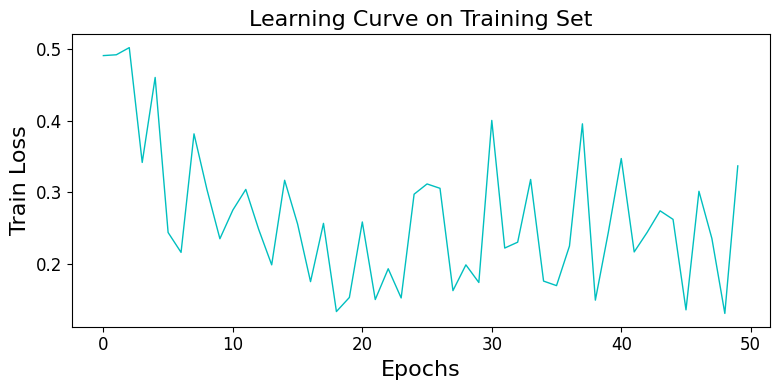

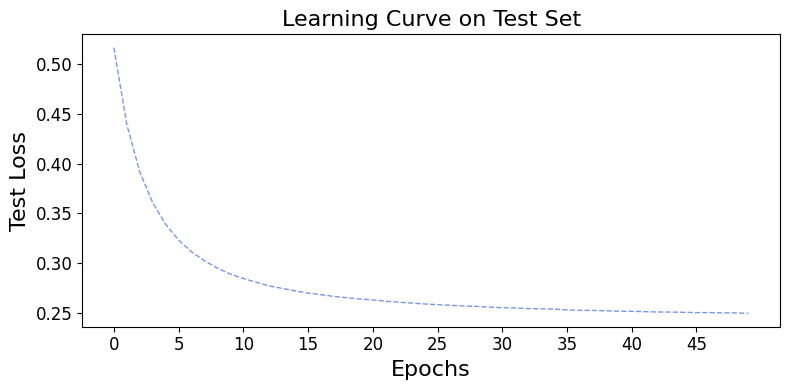

In [102]:
visLearningCurve(train_loss_log, test_loss_log)

In [103]:
# Compute accuracy, TPR, FPR of the model in the validation set
if torch.cuda.is_available():
    x_cs_val = x_cs_val.cuda()
    y_cs_val = y_cs_val.cuda()

acc, tpr, fpr = calculate_metrics_with_BCE(log_reg_torch, x_cs_val, y_cs_val)

Accuracy: 0.8905, TPR: 0.8562, FPR: 0.0762


In [104]:
# Double check the model with statsmodel
# For sanity check, build a logistic regression model using statsmodels
import statsmodels.formula.api as smf
all_columns = "+".join(ames_cs_train.columns.difference(["HighPrice"]))
my_formula = "HighPrice~" + all_columns +'-1'
print(my_formula)

mod_naive = smf.logit(my_formula, data=ames_cs_train)
log_reg_sm = mod_naive.fit()

print(log_reg_sm.summary())

HighPrice~FullBath+GrLivArea+MSSubClass+OverallQual+SaleCondition+TotRmsAbvGrd+YearsSince1950Built-1
         Current function value: 0.204468
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:              HighPrice   No. Observations:                 1314
Model:                          Logit   Df Residuals:                     1288
Method:                           MLE   Df Model:                           25
Date:                Mon, 17 Mar 2025   Pseudo R-squ.:                  0.7050
Time:                        22:38:42   Log-Likelihood:                -268.67
converged:                      False   LL-Null:                       -910.78
Covariance Type:            nonrobust   LLR p-value:                1.968e-255
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
MSSubClass[20] 

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [105]:
# Compute accuracy, TPR, FPR of the model in the validation set
acc, tpr, fpr = calculate_metrics_no_torch(log_reg_sm, ames_cs_test, ames_cs_test['HighPrice'])

Accuracy: 0.9080, TPR: 0.9149, FPR: 0.0983


## Multi Hidden Layer Model for Classification

Although Binary Cross Entropy with Logit Loss is commonly used for binary classification loss, we will be using CrossEntropyLoss, which is more general than the BCELoss.
For multi-class classification, we use CrossEntropyLoss and this is mostly used in image classification. To get you familiar with this loss function, we will be using here even though our problem is binary classification problem.


In [106]:
import torch.nn.functional as F

# define single hidden layer neural network
class SingleHiddenLayerNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SingleHiddenLayerNN, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, 2) # If we are using CrossEntropyLoss, we need to have 2 output nodes for binary classification

    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x

**Important**

We also need to change the dtype and shape of y variables

Now, the output y variable needs to be 1 dimension. Therefore, remove unsqueeze(0) and view(-1,1) from our original code.

Also, CrossEntropy Function requires y to be int type variable. In Pytorch, this belongs to torch.long data type.

In [107]:
# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Assuming the DataFrame has two columns: features and target
        x = torch.tensor(self.data.iloc[idx, 1:].values.astype(float), dtype=torch.float32)
        y = torch.tensor(self.data.iloc[idx,0], dtype=torch.long) # return 1 dimensional tensor
        return x, y

In [108]:
cs_train_dataset = CustomDataset(ames_cs_train_encoded)
# Define a DataLoader
cs_train_loader = DataLoader(cs_train_dataset, batch_size=64, shuffle=True)

cs_val_dataset = CustomDataset(ames_cs_val_encoded)
# Define a DataLoader
cs_val_loader = DataLoader(cs_val_dataset, batch_size=64, shuffle=True)

cs_test_dataset = CustomDataset(ames_cs_test_encoded)
# Define a DataLoader
cs_test_loader = DataLoader(cs_test_dataset, batch_size=64, shuffle=True)

x_cs_val = torch.tensor(ames_cs_val_encoded.iloc[:, 1:].values, dtype=torch.float32)
y_cs_val = torch.tensor(ames_cs_val_encoded.iloc[:,0].values, dtype=torch.long)
x_cs_test = torch.tensor(ames_cs_test_encoded.iloc[:, 1:].values, dtype=torch.float32)
y_cs_test = torch.tensor(ames_cs_test_encoded.iloc[:,0].values, dtype=torch.long)

print(x_cs_val.shape, y_cs_val.shape, x_cs_test.shape, y_cs_test.shape)

torch.Size([621, 27]) torch.Size([621]) torch.Size([989, 27]) torch.Size([989])


In [109]:
y_cs_val = y_cs_val.to(torch.long)

In [110]:
# Define the model and the optimizer
input_dim = ames_cs_train_encoded.shape[1] - 1
hidden_dim = 10
# Define the model and the optimizer
single_hidden_layer = SingleHiddenLayerNN(input_dim, hidden_dim)
learning_rate = 1e-3
optimizer = torch.optim.Adam(single_hidden_layer.parameters(), lr=learning_rate)

# Train model

# Define the loss function: logloss
loss_func = nn.CrossEntropyLoss()
num_epochs = 100
train_loss_log, test_loss_log = train_model(single_hidden_layer, loss_func, num_epochs, optimizer, cs_train_loader, x_cs_val, y_cs_val)

Epoch  1,  Training Loss:    0.6671,  Test Loss:  0.6564
Epoch  2,  Training Loss:    0.6193,  Test Loss:  0.6157
Epoch  3,  Training Loss:    0.5546,  Test Loss:  0.5625
Epoch  4,  Training Loss:    0.4614,  Test Loss:  0.5031
Epoch  5,  Training Loss:    0.4609,  Test Loss:  0.4444
Epoch  6,  Training Loss:    0.4565,  Test Loss:  0.3955
Epoch  7,  Training Loss:    0.2695,  Test Loss:  0.3583
Epoch  8,  Training Loss:    0.4148,  Test Loss:  0.3301
Epoch  9,  Training Loss:    0.3629,  Test Loss:  0.3113
Epoch 10,  Training Loss:    0.4036,  Test Loss:  0.2972
Epoch 11,  Training Loss:    0.2606,  Test Loss:  0.2878
Epoch 12,  Training Loss:    0.1968,  Test Loss:  0.2802
Epoch 13,  Training Loss:    0.2321,  Test Loss:  0.2744
Epoch 14,  Training Loss:    0.3887,  Test Loss:  0.2697
Epoch 15,  Training Loss:    0.1516,  Test Loss:  0.2661
Epoch 16,  Training Loss:    0.1844,  Test Loss:  0.2629
Epoch 17,  Training Loss:    0.2232,  Test Loss:  0.2606
Epoch 18,  Training Loss:    0.

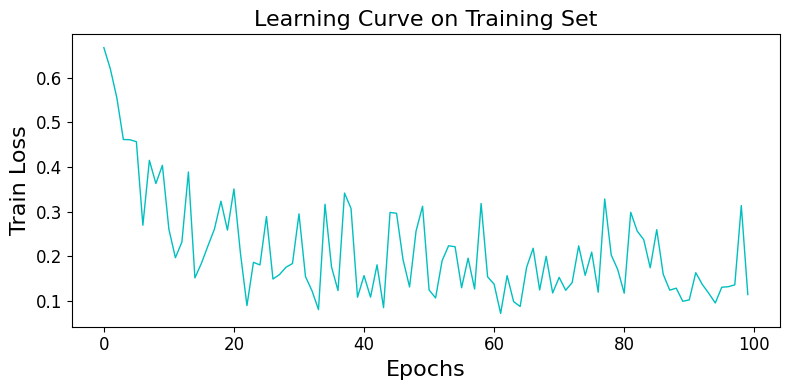

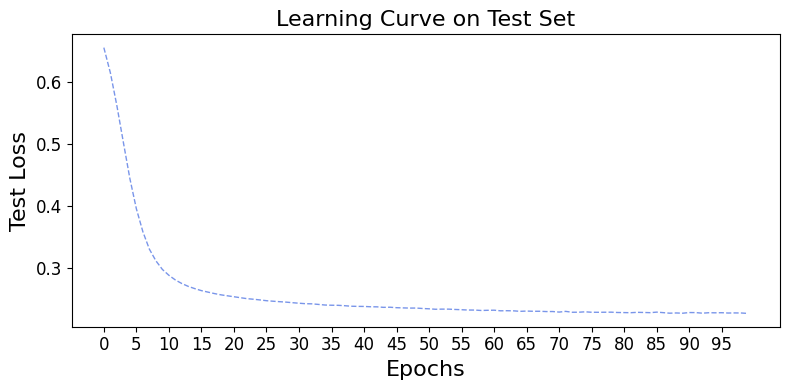

In [111]:
visLearningCurve(train_loss_log, test_loss_log)

In [112]:
# Compute accuracy, TPR, FPR of the model in the validation set
if torch.cuda.is_available():
    single_hidden_layer = single_hidden_layer.cuda()  # Move the model to GPU if available
    x_cs_val = x_cs_val.cuda()  # Move input data to GPU if available
    y_cs_val = y_cs_val.cuda()  # Move target data to GPU if available

acc, tpr, fpr = calculate_metrics_with_CEL(single_hidden_layer, x_cs_val, y_cs_val)

Accuracy: 0.9050, TPR: 0.8856, FPR: 0.0762


In [113]:
# Build Single Hidden Layer with Sigmoid Activation Function
class SingleHiddenLayerSigmoid(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SingleHiddenLayerSigmoid, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, 2) # If we are using CrossEntropyLoss, we need to have 2 output nodes for binary classification

    def forward(self, x):
        x = self.linear1(x)
        x = F.sigmoid(x)
        x = self.linear2(x)
        return x

In [115]:
# Define the model and the optimizer
input_dim = ames_cs_train_encoded.shape[1] - 1
hidden_dim = 10
# Define the model and the optimizer
single_hidden_layer_sigmoid = SingleHiddenLayerSigmoid(input_dim, hidden_dim)
learning_rate = 1e-3
optimizer = torch.optim.Adam(single_hidden_layer_sigmoid.parameters(), lr=learning_rate)

# Train model

# Define the loss function: CrossEntropyLoss
loss_func = nn.CrossEntropyLoss()
num_epochs = 100
train_loss_log, test_loss_log = train_model(single_hidden_layer_sigmoid, loss_func, num_epochs, optimizer, cs_train_loader, x_cs_val, y_cs_val)

Epoch  1,  Training Loss:    0.6949,  Test Loss:  0.7013
Epoch  2,  Training Loss:    0.6675,  Test Loss:  0.6802
Epoch  3,  Training Loss:    0.6604,  Test Loss:  0.6587
Epoch  4,  Training Loss:    0.6335,  Test Loss:  0.6354
Epoch  5,  Training Loss:    0.5988,  Test Loss:  0.6092
Epoch  6,  Training Loss:    0.5690,  Test Loss:  0.5797
Epoch  7,  Training Loss:    0.5796,  Test Loss:  0.5480
Epoch  8,  Training Loss:    0.4892,  Test Loss:  0.5161
Epoch  9,  Training Loss:    0.4714,  Test Loss:  0.4841
Epoch 10,  Training Loss:    0.4375,  Test Loss:  0.4543
Epoch 11,  Training Loss:    0.4292,  Test Loss:  0.4278
Epoch 12,  Training Loss:    0.3438,  Test Loss:  0.4045
Epoch 13,  Training Loss:    0.3751,  Test Loss:  0.3844
Epoch 14,  Training Loss:    0.3942,  Test Loss:  0.3676
Epoch 15,  Training Loss:    0.3428,  Test Loss:  0.3533
Epoch 16,  Training Loss:    0.2307,  Test Loss:  0.3410
Epoch 17,  Training Loss:    0.3287,  Test Loss:  0.3305
Epoch 18,  Training Loss:    0.

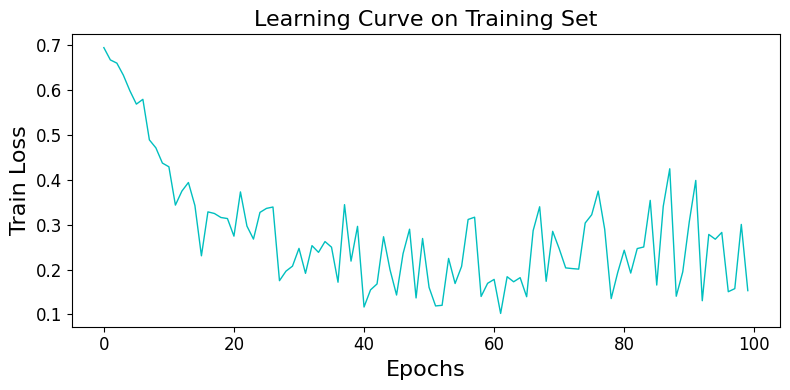

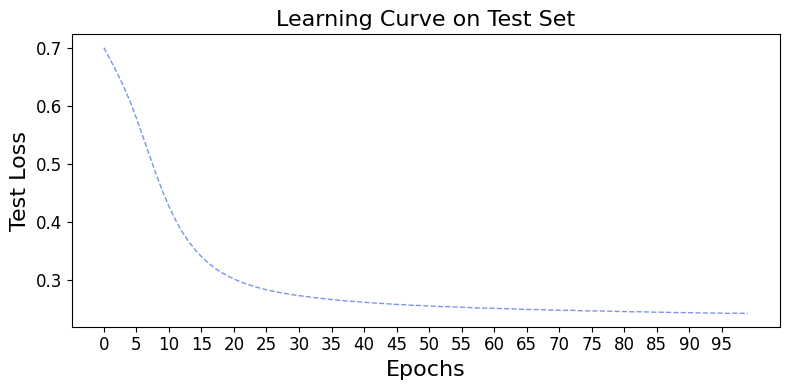

In [116]:
visLearningCurve(train_loss_log, test_loss_log)

In [117]:
# Compute accuracy, TPR, FPR of the model in the validation set
acc, tpr, fpr = calculate_metrics_with_CEL(single_hidden_layer_sigmoid, x_cs_val, y_cs_val)

Accuracy: 0.8953, TPR: 0.8660, FPR: 0.0762


In [118]:
# Show the performance in our selected model
if torch.cuda.is_available():
    x_cs_test = x_cs_test.cuda()
    y_cs_test = y_cs_test.cuda()

acc, tpr, fpr = calculate_metrics_with_CEL(single_hidden_layer_sigmoid, x_cs_test, y_cs_test)

Accuracy: 0.9080, TPR: 0.9128, FPR: 0.0963


In [119]:
# Two Hidden Layer Neural Network
class TwoHiddenLayerNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2):
        super(TwoHiddenLayerNN, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        self.linear2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.linear3 = nn.Linear(hidden_dim2, 2) # If we are using CrossEntropyLoss, we need to have 2 output nodes for binary classification

    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        return x

In [120]:
# Define the model and the optimizer
input_dim = ames_cs_train_encoded.shape[1] - 1
hidden_dim1 = 30
hidden_dim2 = 20
# Define the model and the optimizer
two_hidden_layer = TwoHiddenLayerNN(input_dim, hidden_dim1, hidden_dim2)
learning_rate = 1e-3
optimizer = torch.optim.Adam(two_hidden_layer.parameters(), lr=learning_rate)
# Define the loss function: CrossEntropyLoss
loss_func = nn.CrossEntropyLoss()
num_epochs = 100
train_loss_log, test_loss_log = train_model(two_hidden_layer, loss_func, num_epochs, optimizer, cs_train_loader, x_cs_val, y_cs_val)

Epoch  1,  Training Loss:    0.5971,  Test Loss:  0.6237
Epoch  2,  Training Loss:    0.5116,  Test Loss:  0.5145
Epoch  3,  Training Loss:    0.3713,  Test Loss:  0.3783
Epoch  4,  Training Loss:    0.2032,  Test Loss:  0.3026
Epoch  5,  Training Loss:    0.1444,  Test Loss:  0.2812
Epoch  6,  Training Loss:    0.1526,  Test Loss:  0.2717
Epoch  7,  Training Loss:    0.2550,  Test Loss:  0.2650
Epoch  8,  Training Loss:    0.1222,  Test Loss:  0.2585
Epoch  9,  Training Loss:    0.0774,  Test Loss:  0.2530
Epoch 10,  Training Loss:    0.1007,  Test Loss:  0.2490
Epoch 11,  Training Loss:    0.1596,  Test Loss:  0.2455
Epoch 12,  Training Loss:    0.2222,  Test Loss:  0.2426
Epoch 13,  Training Loss:    0.2554,  Test Loss:  0.2383
Epoch 14,  Training Loss:    0.2499,  Test Loss:  0.2370
Epoch 15,  Training Loss:    0.1808,  Test Loss:  0.2350
Epoch 16,  Training Loss:    0.2900,  Test Loss:  0.2325
Epoch 17,  Training Loss:    0.0376,  Test Loss:  0.2305
Epoch 18,  Training Loss:    0.

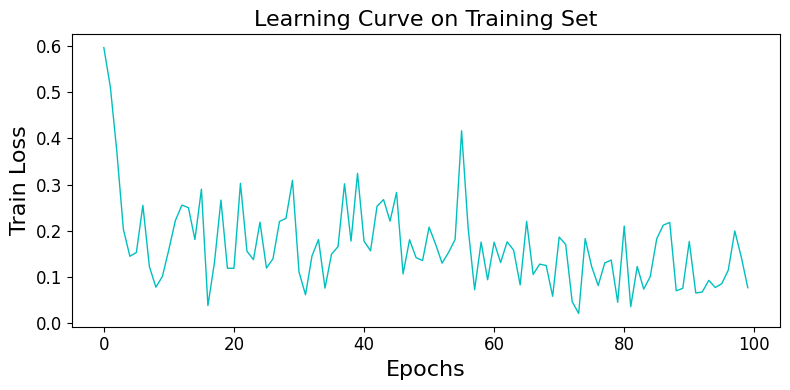

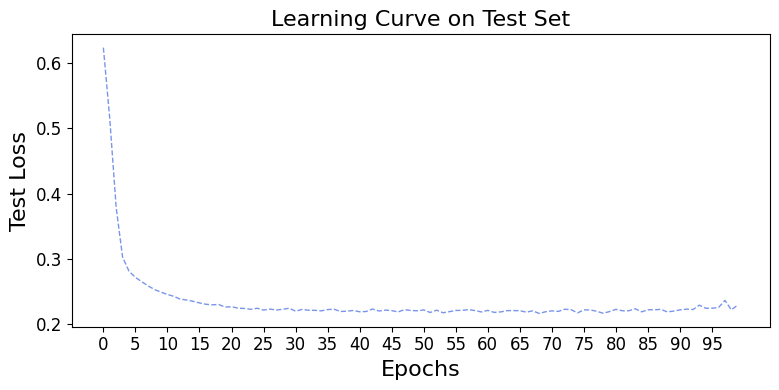

In [121]:
visLearningCurve(train_loss_log, test_loss_log)

In [122]:
# Compute accuracy, TPR, FPR of the model in the validation set
acc, tpr, fpr = calculate_metrics_with_CEL(two_hidden_layer, x_cs_val, y_cs_val)

Accuracy: 0.9066, TPR: 0.8824, FPR: 0.0698
